In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
from scipy.integrate import trapezoid
from scipy.special import jv


In [3]:
plt.rcParams.update({'font.size': 10})
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({
    "text.usetex": True,
})

In [4]:

def apodization_function(theta, focus=3.1e-3, theta_max=np.arcsin(0.67), w_0=(4.4e-3)/2):
    f_0 = w_0/(focus*np.sin(theta_max))
    return np.exp(-np.power(np.sin(theta)/(f_0*np.sin(theta_max)),2))


def integral_i_00(rho, theta, z, focus=3.1e-3, theta_max=np.arcsin(0.67), wavenumber=2*np.pi/(1550e-9)):
    fw = apodization_function(theta, focus=focus, theta_max=theta_max)
    return fw*np.sqrt(np.cos(theta))*np.sin(theta)*(1+np.cos(theta))*jv(0, wavenumber*rho*np.sin(theta))*np.exp(1j*wavenumber*z*np.cos(theta))


def integral_i_01(rho, theta, z, focus=3.1e-3, theta_max=np.arcsin(0.67), wavenumber=2*np.pi/(1550e-9)):
    fw = apodization_function(theta, focus=focus, theta_max=theta_max)
    return fw*np.sqrt(np.cos(theta))*np.power(np.sin(theta),2)*jv(1, wavenumber*rho*np.sin(theta))*np.exp(1j*wavenumber*z*np.cos(theta))


def integral_i_02(rho, theta, z, focus=3.1e-3, theta_max=np.arcsin(0.67), wavenumber=2*np.pi/(1550e-9)):
    fw = apodization_function(theta, focus=focus, theta_max=theta_max)
    return fw*np.sqrt(np.cos(theta))*np.sin(theta)*(1-np.cos(theta))*jv(2, wavenumber*rho*np.sin(theta))*np.exp(1j*wavenumber*z*np.cos(theta))


def compute_electric_field(rho, phi, z, focus=3.1e-3, theta_max=np.arcsin(0.67), wavenumber=2*np.pi/(1550e-9)):
    thetas = np.linspace(0, theta_max, 1000)
    i_00 = trapezoid(integral_i_00(rho, thetas, z), thetas)
    i_01 = trapezoid(integral_i_01(rho, thetas, z), thetas)
    i_02 = trapezoid(integral_i_02(rho, thetas, z), thetas)
    E_amp = (1j*wavenumber*focus/2)*np.exp(-1j*wavenumber*focus)
    return E_amp*np.array([[i_00+i_02*np.cos(2*phi)],[i_02*np.sin(2*phi)],[-2j*i_01*np.cos(phi)]])

def compute_intensity_profile(xs, ys, z=0, power=250e-3, initial_waist=4.2e-3/2):
    xs, ys = np.meshgrid(xs, ys)
    rhos = np.sqrt(np.power(xs,2)+np.power(ys,2))
    phis = np.arctan2(ys, xs)

    E_0 = np.sqrt(2*power/(initial_waist*np.pi*8.85e-12*3e8))



    intensities = np.zeros(rhos.shape)
    for i in range(rhos.shape[0]):
        for j in range(rhos.shape[1]):
            module_e = E_0*np.abs(compute_electric_field(rhos[i,j], phis[i,j], z))
            intensity = np.power(module_e,2).sum()
            intensities[i, j] =intensity
    return xs, ys, intensities


def compute_intensity_gaussian_z():
    zs = np.linspace(-5e-6, 5e-6, 100)
    intensities = np.zeros(zs.shape).astype(np.complex_)
    for i in range(zs.shape[0]):
        module_e = np.abs(compute_electric_field(0, 0, zs[i]))
        intensity = np.power(module_e,2).sum()
        intensities[i] =intensity
    return zs, intensities


In [5]:
na = 0.67
theta_max = np.arcsin(0.67)
focus = 3.1e-3

x_points = np.linspace(-2e-6, 2e-6, 300)
y_points = np.linspace(-2e-6, 2e-6, 300)

xs, ys, intensities = compute_intensity_profile(x_points, y_points)

/var/folders/fy/4wjvjmc95f1fv0gy4d27l6_h0000gn/T/ipykernel_15480/472910508.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(xs/1e-6, ys/1e-6, intensities/intensities.max(),


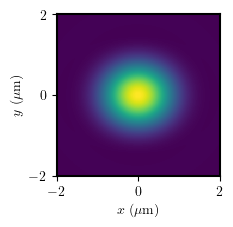

In [8]:
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
factor = 0.7
fig.set_size_inches(3*factor, 3*factor, forward=True)
plt.pcolor(xs/1e-6, ys/1e-6, intensities/intensities.max(), 
           cmap=matplotlib.cm.viridis, vmin=0, vmax=1)
plt.xlabel(r'$x$ ($\mu$m)')
plt.ylabel(r'$y$ ($\mu$m)')
plt.xticks([-2, 0, 2])
plt.yticks([-2, 0, 2])
plt.savefig('../../plots/Chapter 2/spread_point_pcolor.pdf', dpi=300, bbox_inches = 'tight')

plt.show()

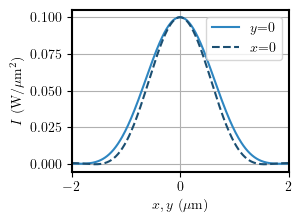

In [10]:
colors = ['#2E86C1', '#85C1E9', '#1B4F72']
fig = plt.figure(figsize=(5.4*1.3*10, 10*4.2))
factor = 0.7
fig.set_size_inches(4*factor, 3*factor, forward=True)
plt.plot(x_points/1e-6, 1e-12*intensities[int(ys.shape[1]/2),:], color=colors[0])
plt.plot(y_points/1e-6, 1e-12*intensities[:, int(ys.shape[1]/2)], color=colors[2], linestyle='dashed')
plt.xlabel(r'$x, y$ ($\mu$m)')
plt.ylabel(r'$I$ (W/$\mu\textrm{m}^2$)') 
plt.xticks([-2, 0, 2])
plt.xlim([-2,2])
plt.grid()
plt.legend(['$y$=0', '$x$=0'], loc='upper right')
plt.savefig('../../plots/Chapter 2/spread_function_line.pdf', dpi=300, bbox_inches = 'tight')
plt.show()